In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import shapely

In [2]:
# swb_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_swb2.json'
#     )

# ponds_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells/output/17/gobindpur/gobindpur_COMBINED_GEOMETRY',
#     'gobindpur_COMBINED_GEOMETRY.shp'
#     )

# mws_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_mws.json'
#     )

# admin_boundary_layer_path = os.path.join(
#     os.environ['DATA'],
#     'ponds_and_wells',
#     'gobindpur_boundary.geojson'
#     )

#new files (apparently all outputs of this block were actually tehsil boundaries, so they were fixed to only be the block boundaries)
swb_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur',
    'swb.json'
    )

ponds_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur',
    'gobindpur_ponds.geojson'
    )

mws_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur',
    'mws.json'
    )

admin_boundary_layer_path = os.path.join(
    os.environ['DATA'],
    'ponds_and_wells',
    'gobindpur',
    'admin_boundary.json'
    )



In [3]:
ponds_gdf = gpd.read_file(ponds_layer_path)

swb_gdf = gpd.read_file(swb_layer_path)

mws_gdf = gpd.read_file(mws_layer_path)

admin_boundary_gdf = gpd.read_file(admin_boundary_layer_path)

In [4]:
def split_multipolygon_into_individual_polygons(data_gdf):
    data_gdf = data_gdf.explode()
    return data_gdf

def clip_to_boundary(data_gdf,boundary_gdf):
    data_gdf = data_gdf.sjoin(boundary_gdf[['geometry']],how = 'inner')
    data_gdf.drop(['index_right'],axis=1,inplace=True)
    return data_gdf

def change_crs(data_gdf,crs):
    data_gdf.to_crs(crs)
    return data_gdf

def generate_pond_id(data_gdf):
    data_gdf.drop(['FID'],axis=1,inplace=True,errors='ignore') #drop if the column exists
    data_gdf['pond_id'] = range(data_gdf.shape[0])
    return data_gdf

def dissolve_boundary(data_gdf):
    data_gdf = data_gdf.dissolve()
    return data_gdf

def uid_for_ponds(mws_id_list, pond_id):
    # print(row)
    row_uid = [str(x) for x in mws_id_list]
    row_uid = "_".join(row_uid)
    row_uid = "_".join([row_uid, str(pond_id)])
    return row_uid

In [ ]:
if (ponds_gdf.shape[0] == 1):
    ponds_gdf = split_multipolygon_into_individual_polygons(ponds_gdf)
ponds_gdf = generate_pond_id(ponds_gdf)

In [20]:
ponds_gdf

,id,geometry
0,00000000000000000000,"POLYGON ((86.20013 22.65664, 86.20013 22.65664..."
1,00000000000000000001,"POLYGON ((86.19875 22.65755, 86.19876 22.65755..."
2,00000000000000000002,"POLYGON ((86.19759 22.65508, 86.19759 22.65507..."
3,00000000000000000003,"POLYGON ((86.19678 22.63558, 86.19678 22.63558..."
4,00000000000000000004,"POLYGON ((86.1951 22.63293, 86.1951 22.63291, ..."
...,...,...
694,000000000000000002b6,"POLYGON ((85.84891 22.52863, 85.84891 22.52863..."
695,000000000000000002b7,"POLYGON ((85.84959 22.5276, 85.84959 22.52759,..."
696,000000000000000002b8,"POLYGON ((85.84603 22.51937, 85.84604 22.51937..."
697,000000000000000002b9,"POLYGON ((85.83354 22.52361, 85.83356 22.5236,..."


In [6]:
# ponds_gdf.head()

In [7]:
if (admin_boundary_gdf.shape[0] > 1):
    admin_boundary_gdf = dissolve_boundary(admin_boundary_gdf)

In [8]:
mws_outer_boundary_gdf = dissolve_boundary(mws_gdf)

In [9]:
# admin_boundary_gdf

In [10]:
ponds_gdf = clip_to_boundary(
    data_gdf=ponds_gdf,
    boundary_gdf= mws_outer_boundary_gdf #admin_boundary_gdf
)

In [11]:
# ponds_gdf.shape

In [12]:
swb_gdf = clip_to_boundary(
    data_gdf=swb_gdf,
    boundary_gdf= mws_outer_boundary_gdf #admin_boundary_gdf
)

In [13]:
swb_gdf.shape

(2306, 36)

In [14]:
# swb_gdf = change_crs(
#     data_gdf=swb_gdf,
#     crs='crs:7755'
# )

# ponds_gdf = change_crs(
#     data_gdf=ponds_gdf,
#     crs='crs:7755'
# )

### Create merged dataframe

1. Add standalone swb

In [15]:
intersecting_UIDs = swb_gdf.sjoin(ponds_gdf)['UID'].tolist()

In [16]:
standalone_swb_gdf = swb_gdf[~swb_gdf['UID'].isin(intersecting_UIDs)]

In [17]:
standalone_swb_gdf.shape

(1774, 36)

In [18]:
merged_gdf = standalone_swb_gdf

2. Add standalone ponds

In [19]:
intersecting_pond_ids = ponds_gdf.sjoin(swb_gdf)['pond_id'].tolist()

KeyError: 'pond_id'

In [ ]:
standalone_ponds_gdf = ponds_gdf[~ponds_gdf['pond_id'].isin(intersecting_pond_ids)]

 Add UID column to standalone ponds

In [ ]:
mws_gdf.rename(columns={"uid": "MWS_UID"}, inplace=True)
mws_uid_ponds_df = standalone_ponds_gdf.sjoin(
    mws_gdf[["MWS_UID", "geometry"]], how="left"
)

In [ ]:
# mws_uid_ponds_df

In [ ]:
mws_uid_ponds_df.drop("index_right", inplace=True, axis=1)
pond_mws_intersections_df = (
    mws_uid_ponds_df.groupby(["pond_id"])["MWS_UID"].unique().reset_index()
)
pond_mws_intersections_df["UID"] = pond_mws_intersections_df.apply(
    lambda row: uid_for_ponds(row.MWS_UID, row.pond_id), axis=1
)
standalone_ponds_gdf = standalone_ponds_gdf.merge(
    pond_mws_intersections_df[["pond_id", "UID"]]
)

In [ ]:
# standalone_ponds_gdf.shape

In [ ]:
merged_gdf = pd.concat([merged_gdf,
                        standalone_ponds_gdf])

In [ ]:
merged_gdf.shape

#### Intersection scenarios

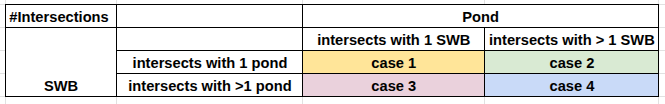

In [ ]:
intersections_gdf = swb_gdf.sjoin(ponds_gdf)

In [ ]:
# ponds_gdf

In [ ]:
intersections_gdf.shape

In [ ]:
# ponds_gdf

In [ ]:
swb_intersections_df = intersections_gdf.groupby(['UID'])['pond_id'].unique().reset_index()

In [ ]:
pond_intersections_df = intersections_gdf.groupby(['pond_id'])['UID'].unique().reset_index()

In [ ]:
merged_gdf.shape

In [ ]:
single_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) == 1]

In [ ]:
len(single_intersection_uids)

In [ ]:
# single_intersection_uids

In [ ]:
# pond_intersections_df

In [ ]:
case_1_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) == 1):
                case_1_swb_ids.append(x)

In [ ]:
len(case_1_swb_ids)

In [ ]:
# ponds_gdf

In [ ]:
case1_gdf = swb_gdf[swb_gdf['UID'].isin(case_1_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [ ]:
case1_gdf.drop(['index_right'],axis=1,inplace=True)

In [ ]:
for index,row in case1_gdf.iterrows():
    case1_gdf.loc[index,'geometry'] = shapely.ops.unary_union(
        [
            row['geometry'],
            ponds_gdf[ponds_gdf['pond_id'] == row['pond_id']]['geometry'].iloc[0]
        ]
    ) #new find: without the .loc it wont update the original value of the row geometries. like row['geometry] = unary_union(row['geometry'],pond['geometry']) didnt update the value


In [ ]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case1_gdf
        ]
)

In [ ]:
merged_gdf.shape

Case 2: Cases of ponds intersecting with more than 1 SWBs, and SWBs intersecting with only 1 pond
- In these cases we currently dont merge the boundary of the intersecting pond and swbs, but just tag the pond which intersects with an SWB, and have 1 row per SWB. 

In [ ]:
# single_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) == 1]
# #ponds that intersect with only 1 swb

# multi_intersection_pond_ids = [row['pond_id'] for ind,row in pond_intersections_df.iterrows() if len(row['UID']) > 1]
# #ponds that intersect with only 1 swb

In [ ]:
# print(len(single_intersection_pond_ids))
# print(len(multi_intersection_pond_ids))

In [ ]:
# pond_intersections_df

In [ ]:
# swb_intersections_df

In [ ]:
case2_swb_ids = []
for x in single_intersection_uids:
    for y in pond_intersections_df['UID']:
        if (x in y):
            if (len(y) > 1):
                case2_swb_ids.append(x)

In [ ]:
len(case2_swb_ids)

In [ ]:
case2_gdf = swb_gdf[swb_gdf['UID'].isin(case2_swb_ids)].sjoin(
    ponds_gdf,
    how='left'
)

In [ ]:
# case2_gdf.head()

In [ ]:
case2_gdf.drop(['index_right'],axis=1,inplace=True)

In [ ]:
case2_gdf.shape

In [ ]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case2_gdf
        ]
)

In [ ]:
merged_gdf.shape

Case 3: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with only 1 SWB  
Case 4: Cases of SWB intersecting with more than 1 ponds, and the corresponding ponds intersecting with more than 1 SWB  

It makes sense to combine these cases wrt the dataframe

In [ ]:
multi_intersection_uids = [row['UID'] for ind,row in swb_intersections_df.iterrows() if len(row['pond_id']) > 1]

In [ ]:
multi_intersection_uids

In [ ]:
case3_4_swb_ids = []
case3_4_pond_ids = []
for x in multi_intersection_uids:
    for ind,row in pond_intersections_df.iterrows():
        if (x in row['UID']):
            if (len(row['UID']) >= 1):
                # print(row['pond_id'])
                case3_4_swb_ids.append(x)
                case3_4_pond_ids.append(row['pond_id'])

In [ ]:
len(case3_4_swb_ids) #again these are intersections, not unique swb ids

In [ ]:
case3_4_gdf = swb_gdf[swb_gdf['UID'].isin(case3_4_swb_ids)].sjoin(
    ponds_gdf[ponds_gdf['pond_id'].isin(case3_4_pond_ids)],
    how='left'
)

Learning:
* Apparently list/set or any multiple values is not a good idea to assign to a cell in pandas.  

- https://stackoverflow.com/questions/53116286/how-to-assign-an-entire-list-to-each-row-of-a-pandas-dataframe
- https://stackoverflow.com/questions/52552198/how-to-set-the-value-of-a-pandas-column-as-list/52563718#52563718


Therefore, in cases where a single SWB intersects with multiple ponds, we go with creating multiple rows
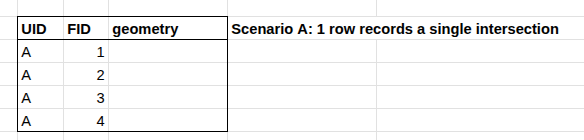

In [ ]:
swb_ponds_case3_4 = case3_4_gdf.groupby(['UID'])['pond_id'].agg(set).reset_index()
swb_ponds_case3_4

In [ ]:
swb_ponds_case3_4['pond_id'] = swb_ponds_case3_4['pond_id'].apply(lambda x: list(x))

In [ ]:
# swb_ponds_case3_4

In [ ]:
case3_4_merged_geom = []
for swb in swb_ponds_case3_4["UID"]:
    # get corresponding farmpond geometries and merge them
    # print(swb)
    merged_geom = swb_gdf[swb_gdf["UID"] == swb]["geometry"].iloc[0]
    # print(merged_geom)
    # case3_gdf.loc[case3_gdf['UID'] == swb,'pond_id'] = np.nan
    for pond in list(
        swb_ponds_case3_4[swb_ponds_case3_4["UID"] == swb]["pond_id"].iloc[0]
    ):
        merged_geom = shapely.ops.unary_union(
            [
                merged_geom,
                ponds_gdf[ponds_gdf["pond_id"] == pond]["geometry"].iloc[0],
            ]
        )
    case3_4_merged_geom.append(merged_geom)
    case3_4_gdf.loc[case3_4_gdf["UID"] == swb, "geometry"] = merged_geom

In [ ]:
case3_4_gdf

In [ ]:
case3_4_gdf.drop(['index_right'],axis=1,inplace=True)

In [ ]:
merged_gdf = \
    pd.concat(
        [
            merged_gdf,
            case3_4_gdf
        ]
)

In [ ]:
merged_gdf.shape

In [ ]:
merged_gdf

In [ ]:
# merged_gdf.dtypes